In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torch.nn import Parameter, Linear, Sequential, BatchNorm1d, ReLU
import torch.nn.functional as F


from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_remaining_self_loops, remove_self_loops, softmax

#from torch_geometric.nn.conv import MessagePassing
#from torch_geometric.nn import GCNConv, GATConv, EdgeConv
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
from torch_geometric.nn.inits import glorot, zeros


import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error,precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler

#from evaluate import get_best_performance_data, get_val_performance_data, get_full_err_scores


from scipy.stats import iqr

In [3]:
import matplotlib

In [4]:
print(matplotlib.__version__)

3.5.2


In [5]:

data_train = pd.read_excel (r'/home/jbara/Desktop/semester 2/data lab/dataset/swat_train.xlsx', skiprows=[0])
data_test = pd.read_excel (r'/home/jbara/Desktop/semester 2/data lab/dataset/swat_test.xlsx', skiprows=[0])

/home/jbara/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:

columns = list(data_train.columns)
data_test.columns = columns 

In [7]:

data_train['Normal/Attack'] = data_train['Normal/Attack'].replace('Normal', 0)
data_train.columns = data_train.columns.str.replace('Normal/Attack', 'attack')

data_test.columns = data_test.columns.str.replace('Normal/Attack', 'attack')
data_test['attack'] = data_test['attack'].replace('Normal', 0)
data_test['attack'] = data_test['attack'].replace('Attack', 1)
data_test['attack'] = data_test['attack'].replace('A ttack', 1)

In [8]:

data_train_labels = data_train.attack
data_test_labels = data_test.attack

data_train.drop([' Timestamp', 'attack'], axis='columns', inplace=True)
data_test.drop([' Timestamp', 'attack'], axis='columns', inplace=True)

In [9]:

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return self.data.shape[0] - self.seq_length

    def __getitem__(self, index):
        return (self.data[index:index+self.seq_length], self.data[index+self.seq_length])


# Normalize data
scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

# Convert data to DataLoader form
seq_length = 10
batch_size = 64
train_dataset = TimeSeriesDataset(data_train, seq_length)
test_dataset = TimeSeriesDataset(data_test, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions

num_features = data_train.shape[1]
hidden_layer_size = 100
model = LSTM(num_features, hidden_layer_size, num_features)

In [11]:

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for i in range(epochs):
    for seq, labels in train_loader:
        seq = seq.float()  # convert seq to float
        labels = labels.float()  # convert labels to float
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%1 == 0:
        print(f'epoch: {i+1:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i+1:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00024631
epoch:   2 loss: 0.00019825
epoch:   3 loss: 0.00017596
epoch:   4 loss: 0.00017695
epoch:   5 loss: 0.00013573
epoch:   6 loss: 0.00011473
epoch:   7 loss: 0.00006193
epoch:   8 loss: 0.00009542
epoch:   9 loss: 0.00009858
epoch:  10 loss: 0.00009486
epoch:  10 loss: 0.0000948562


In [12]:
model

LSTM(
  (lstm): LSTM(51, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=51, bias=True)
)

In [13]:

lstm_outputs = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Do not compute gradients
    for seq, _ in train_loader:
        seq = seq.float()  # Ensure the data is the correct type
        output = model(seq)  # Get the model's predictions
        lstm_outputs.append(output)
lstm_outputs = torch.cat(lstm_outputs)
lstm_outputs = lstm_outputs.numpy()

In [14]:

#lstm_outputs.shape = (494990, 51)

In [15]:

# Compute a correlation matrix from the LSTM outputs
correlation_matrix = np.corrcoef(lstm_outputs, rowvar=False)
#remove loops
np.fill_diagonal(correlation_matrix, 0)
# Only consider correlations >= 0.5
correlation_matrix[np.abs(correlation_matrix) < 0.5] = 0


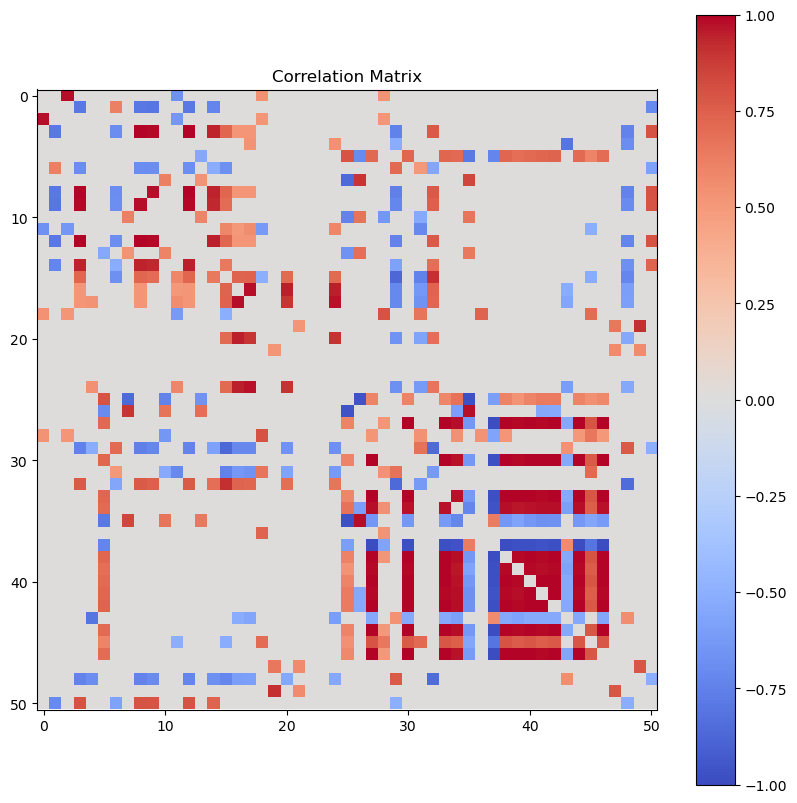

In [16]:

plt.figure(figsize=(10,10))  # You may want to adjust the size depending on your matrix
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix')
plt.show()

In [17]:
import networkx as nx

In [18]:
print(nx.__version__)

2.8.4


In [19]:

import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch_geometric.data as geom_data
import networkx as nx
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
G = nx.from_numpy_matrix(correlation_matrix)

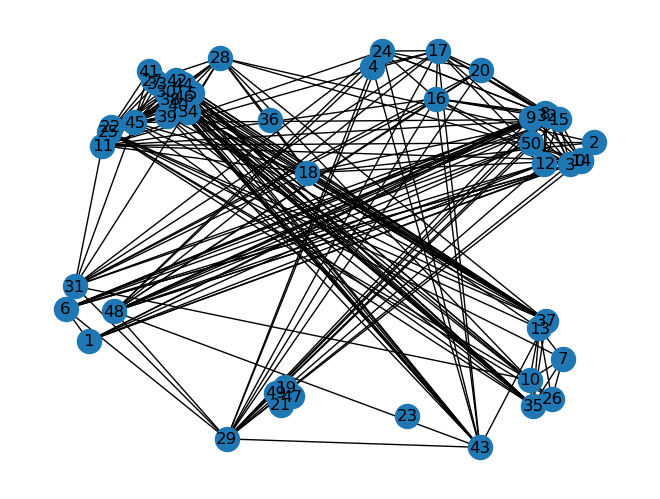

In [20]:

nx.draw(G, with_labels=True)
plt.show()

In [21]:
correlation_matrix.shape

(51, 51)

In [22]:

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.conv2 = GCNConv(128, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [23]:

from torch_geometric.data import Data
# Get the indices of the edges in the adjacency matrix
edge_index = np.argwhere(correlation_matrix > 0).T  # Shape: [2, num_edges]
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Use the LSTM outputs as node features
x = torch.tensor(lstm_outputs, dtype=torch.float)


y = torch.tensor(data_train_labels[:494990])  # Shape: [num_nodes]

data = Data(x=x, edge_index=edge_index, y=y)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
y.shape

torch.Size([494990])

In [26]:

model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, loss.item()))



Epoch: 000, Loss: 0.00000
Epoch: 001, Loss: 0.00000
Epoch: 002, Loss: 0.00000
Epoch: 003, Loss: 0.00000
Epoch: 004, Loss: 0.00000
Epoch: 005, Loss: 0.00000
Epoch: 006, Loss: 0.00000
Epoch: 007, Loss: 0.00000
Epoch: 008, Loss: 0.00000
Epoch: 009, Loss: 0.00000
Epoch: 010, Loss: 0.00000
Epoch: 011, Loss: 0.00000
Epoch: 012, Loss: 0.00000
Epoch: 013, Loss: 0.00000
Epoch: 014, Loss: 0.00000
Epoch: 015, Loss: 0.00000
Epoch: 016, Loss: 0.00000
Epoch: 017, Loss: 0.00000
Epoch: 018, Loss: 0.00000
Epoch: 019, Loss: 0.00000
Epoch: 020, Loss: 0.00000
Epoch: 021, Loss: 0.00000
Epoch: 022, Loss: 0.00000
Epoch: 023, Loss: 0.00000
Epoch: 024, Loss: 0.00000
Epoch: 025, Loss: 0.00000
Epoch: 026, Loss: 0.00000
Epoch: 027, Loss: 0.00000
Epoch: 028, Loss: 0.00000
Epoch: 029, Loss: 0.00000
Epoch: 030, Loss: 0.00000
Epoch: 031, Loss: 0.00000
Epoch: 032, Loss: 0.00000
Epoch: 033, Loss: 0.00000
Epoch: 034, Loss: 0.00000
Epoch: 035, Loss: 0.00000
Epoch: 036, Loss: 0.00000
Epoch: 037, Loss: 0.00000
Epoch: 038, 

Epoch: 001, Loss: 6.9263
Epoch: 002, Loss: 2.7972
Epoch: 003, Loss: 1.3889
Epoch: 004, Loss: 1.0423
Epoch: 005, Loss: 0.9247
Epoch: 006, Loss: 0.8988
Epoch: 007, Loss: 0.8618
Epoch: 008, Loss: 0.8244
Epoch: 009, Loss: 0.7881
Epoch: 010, Loss: 0.7540
Epoch: 011, Loss: 0.7336
Epoch: 012, Loss: 0.7290
Epoch: 013, Loss: 0.7260
Epoch: 014, Loss: 0.7251
Epoch: 015, Loss: 0.7237
Epoch: 016, Loss: 0.7273
Epoch: 017, Loss: 0.7202
Epoch: 018, Loss: 0.7203
Epoch: 019, Loss: 0.7193
Epoch: 020, Loss: 0.7195
Epoch: 021, Loss: 0.7178
Epoch: 022, Loss: 0.7165
Epoch: 023, Loss: 0.7144
Epoch: 024, Loss: 0.7116
Epoch: 025, Loss: 0.7076
Epoch: 026, Loss: 0.7081
Epoch: 027, Loss: 0.7073
Epoch: 028, Loss: 0.7037
Epoch: 029, Loss: 0.7035
Epoch: 030, Loss: 0.7022
Epoch: 031, Loss: 0.7021
Epoch: 032, Loss: 0.7001
Epoch: 033, Loss: 0.7000
Epoch: 034, Loss: 0.7012
Epoch: 035, Loss: 0.6978
Epoch: 036, Loss: 0.6985
Epoch: 037, Loss: 0.6981
Epoch: 038, Loss: 0.6971
Epoch: 039, Loss: 0.6965
Epoch: 040, Loss: 0.6961


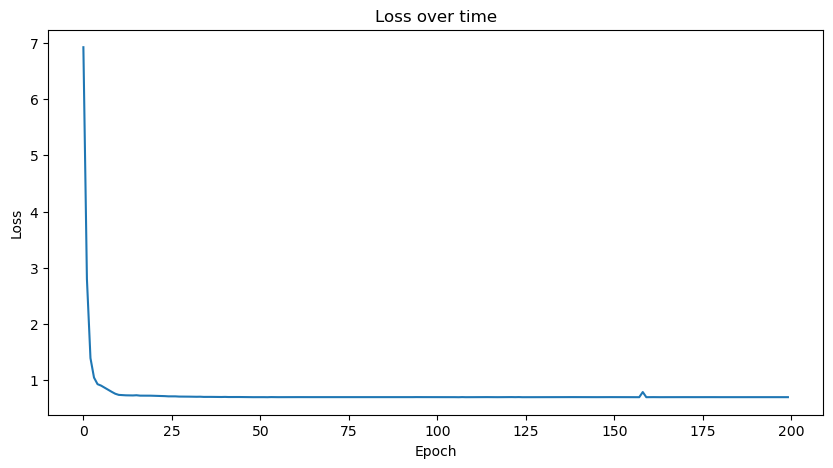

In [27]:

import torch
from torch_geometric.nn import GCNConv, GAE, VGAE

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

out_channels = 16
encoder = Encoder(data.num_features, out_channels)
model = GAE(encoder)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, edge_index)
    loss = model.recon_loss(z, edge_index)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    return float(loss)

loss_values = []
for epoch in range(1, 201):
    loss = train()
    print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch, loss))

# After training the model, we can detect anomalies based on the reconstruction error
model.eval()
with torch.no_grad():
    z = model.encode(x, edge_index)
    recon_error = model.recon_loss(z, edge_index).item()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values)
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


Epoch [1/200], Loss: 0.1283
Epoch [11/200], Loss: 0.0734
Epoch [21/200], Loss: 0.0545
Epoch [31/200], Loss: 0.0372
Epoch [41/200], Loss: 0.0372
Epoch [51/200], Loss: 0.0372
Epoch [61/200], Loss: 0.0373
Epoch [71/200], Loss: 0.0373
Epoch [81/200], Loss: 0.0372
Epoch [91/200], Loss: 0.0372
Epoch [101/200], Loss: 0.0372
Epoch [111/200], Loss: 0.0373
Epoch [121/200], Loss: 0.0373
Epoch [131/200], Loss: 0.0372
Epoch [141/200], Loss: 0.0372
Epoch [151/200], Loss: 0.0372
Epoch [161/200], Loss: 0.0372
Epoch [171/200], Loss: 0.0373
Epoch [181/200], Loss: 0.0373
Epoch [191/200], Loss: 0.0372


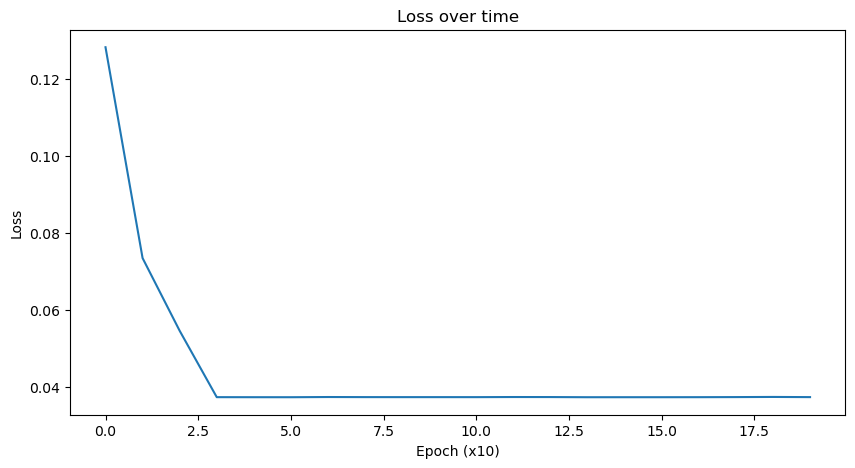

In [28]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define some parameters
input_dim = lstm_outputs.shape[1]
encoding_dim = 64

# Instantiate the autoencoder model
autoencoder = Autoencoder(input_dim, encoding_dim)
autoencoder.to(device)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
epochs = 200
losses = []
for epoch in range(epochs):
    for seq, _ in train_loader:
        seq = seq.float().to(device)
        # Forward pass
        outputs = autoencoder(seq)
        # Compute the loss
        loss = loss_function(outputs, seq)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        losses.append(loss.item())

# Plot the training losses
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Loss over time')
plt.xlabel('Epoch (x10)')
plt.ylabel('Loss')
plt.show()

Epoch [1/200], Loss: 0.0003
Epoch [11/200], Loss: 0.0001
Epoch [21/200], Loss: 0.0001
Epoch [31/200], Loss: 0.0001
Epoch [41/200], Loss: 0.0001
Epoch [51/200], Loss: 0.0001
Epoch [61/200], Loss: 0.0001
Epoch [71/200], Loss: 0.0001
Epoch [81/200], Loss: 0.0001
Epoch [91/200], Loss: 0.0001
Epoch [101/200], Loss: 0.0001
Epoch [111/200], Loss: 0.0001
Epoch [121/200], Loss: 0.0000
Epoch [131/200], Loss: 0.0000
Epoch [141/200], Loss: 0.0000
Epoch [151/200], Loss: 0.0001
Epoch [161/200], Loss: 0.0000
Epoch [171/200], Loss: 0.0000
Epoch [181/200], Loss: 0.0001
Epoch [191/200], Loss: 0.0000


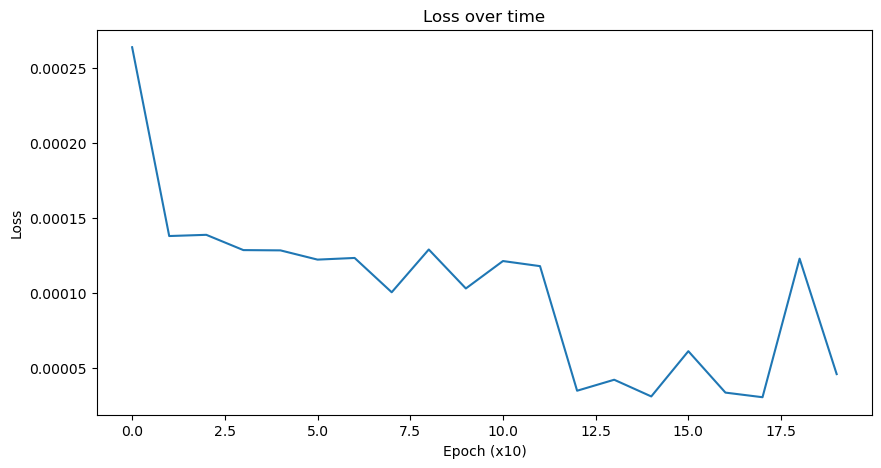

In [29]:
#########################3
#########################
class DeepAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoencoder, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, encoding_dim)

        # Decoder
        self.fc4 = nn.Linear(encoding_dim, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, input_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)  # No activation on final layer
        return x
    
    
# Define some parameters
input_dim = lstm_outputs.shape[1]
encoding_dim = 64

# Instantiate the autoencoder model
autoencoder = DeepAutoencoder(input_dim, encoding_dim)
autoencoder.to(device)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
epochs = 200
losses = []
for epoch in range(epochs):
    for seq, _ in train_loader:
        seq = seq.float().to(device)
        # Forward pass
        outputs = autoencoder(seq)
        # Compute the loss
        loss = loss_function(outputs, seq)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        losses.append(loss.item())

# Plot the training losses
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Loss over time')
plt.xlabel('Epoch (x10)')
plt.ylabel('Loss')
plt.show()

In [74]:
reconstruction_errors = []
model.eval()
with torch.no_grad():
    for seq, _ in test_loader:
        for e in seq:
            e = e.float().to(device)
            outputs = autoencoder(e)
            #print(outputs)
            reconstruction_error = loss_function(outputs, e)
            reconstruction_errors.append(reconstruction_error.item())

# Compute some threshold (for example, the 95th percentile of the reconstruction errors)
threshold = np.percentile(reconstruction_errors, 95)

# Anything with a reconstruction error above the threshold is an anomaly
anomalies = np.array(reconstruction_errors) > threshold

In [86]:
data_test_labels = data_test_labels[:449909].values

In [90]:
anomalies = [int(val) for val in anomalies]

In [91]:
from sklearn.metrics import precision_score, recall_score

In [92]:
precision = precision_score(data_test_labels, anomalies)

# Calculate recall
recall = recall_score(data_test_labels, anomalies)

print("Precision:", precision)
print("Recall:", recall)

Precision: 1.0
Recall: 0.4118562457662804
